In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Setting parameters (these values can be changed)
nrows = 1000
ncols = 1000
xcenter = -0.4601222
ycenter = .570286
bound   = .002
x_domain, y_domain = np.linspace(xcenter-bound, xcenter+bound, ncols), np.linspace(ycenter-bound, ycenter+bound, nrows)
max_iterations = 2000  # any positive integer value
colormap = "nipy_spectral"  # set to any matplotlib valid colormap


def mandelbrot(x, y):
    z = 0
    p = 2
    c = complex(x, y)
    for iteration_number in range(max_iterations):
        if abs(z) >= 2:
            return iteration_number
        else:
            z = z**p + c
    return 0

def plot_data(iteration_array):
    # Plotting the data
    ax = plt.axes()
    ax.set_aspect("equal")
    graph = ax.pcolormesh(x_domain, y_domain, iteration_array, cmap=colormap,
                          norm=matplotlib.colors.LogNorm())
    plt.colorbar(graph)
    plt.xlabel("Real-Axis")
    plt.ylabel("Imaginary-Axis")
    plt.show()

In [3]:
%%time
iteration_array = np.zeros((nrows, ncols))
for (i, x) in enumerate(x_domain):
    for (j, y) in enumerate(y_domain):
        iteration_array[j, i] = mandelbrot(x, y)

CPU times: user 15.9 s, sys: 6.87 ms, total: 16 s
Wall time: 16 s


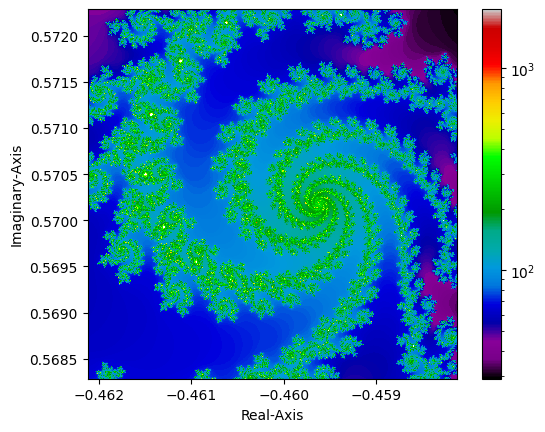

In [4]:
plot_data(iteration_array)

In [5]:
import sys

print(sys._is_gil_enabled())

False


In [6]:
def worker(j_y):
    for (i, x) in enumerate(x_domain):
        for (j, y) in j_y:
            iteration_array[j, i] = mandelbrot(x, y)

1 workers:
CPU times: user 17 s, sys: 4.98 ms, total: 17 s
Wall time: 17 s


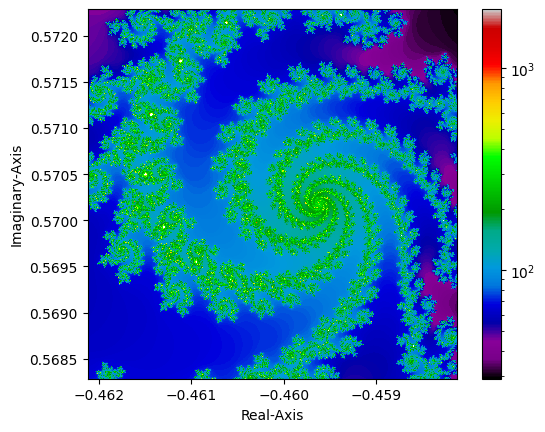

2 workers:
CPU times: user 17.1 s, sys: 1.99 ms, total: 17.1 s
Wall time: 8.54 s


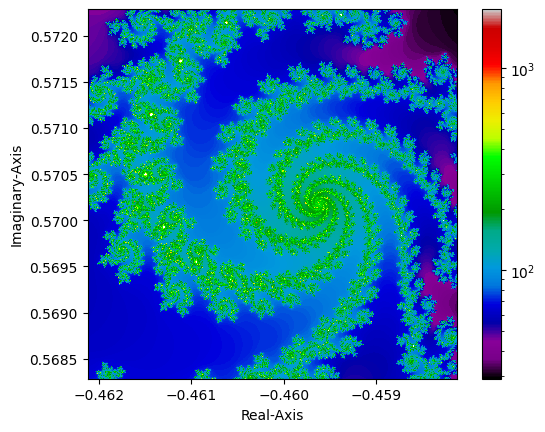

4 workers:
CPU times: user 17.4 s, sys: 4.99 ms, total: 17.4 s
Wall time: 4.39 s


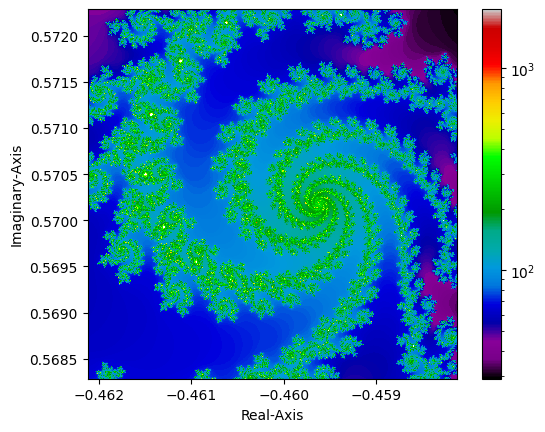

8 workers:
CPU times: user 18.3 s, sys: 5 ms, total: 18.3 s
Wall time: 2.31 s


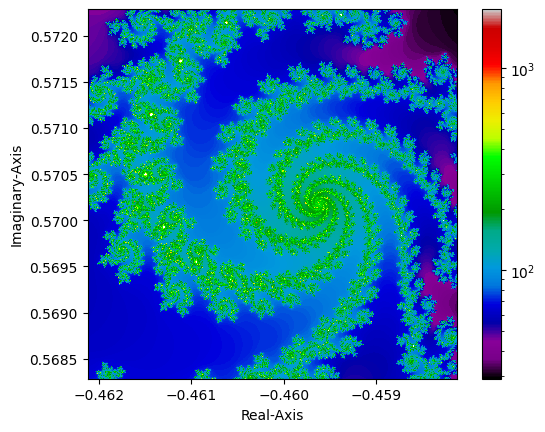

16 workers:
CPU times: user 21 s, sys: 14 ms, total: 21 s
Wall time: 1.34 s


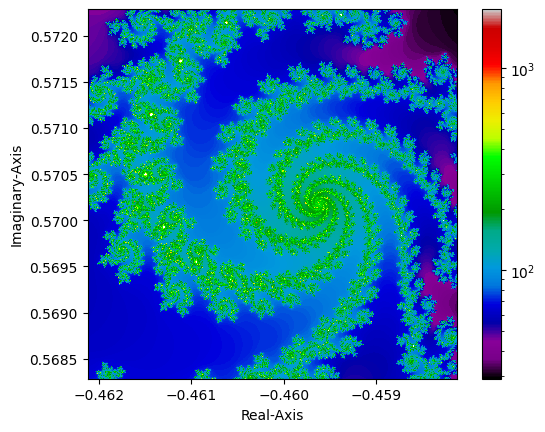

32 workers:
CPU times: user 25.3 s, sys: 17 ms, total: 25.3 s
Wall time: 858 ms


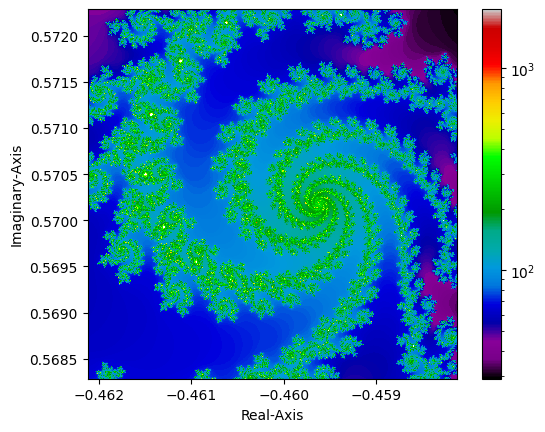

64 workers:
CPU times: user 34 s, sys: 26 ms, total: 34 s
Wall time: 773 ms


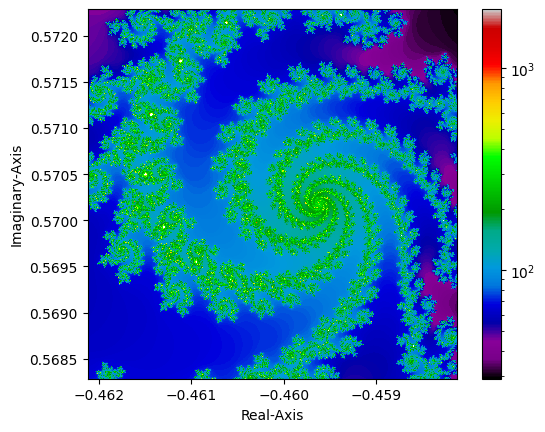

128 workers:
CPU times: user 33.7 s, sys: 30 ms, total: 33.8 s
Wall time: 770 ms


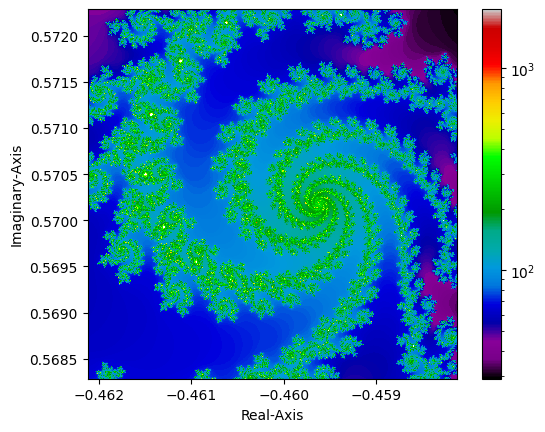

In [7]:
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import itertools

def run_thread_pool(num_workers):
    with ThreadPoolExecutor(max_workers=num_workers) as tpe:
        chunks = itertools.batched(enumerate(y_domain), 4, strict=True)
        futures = [tpe.submit(worker, arg) for arg in chunks]
        # block until all work finishes
        concurrent.futures.wait(futures)

for i in range(8):
    iteration_array = np.zeros((nrows, ncols))
    print(f"{2**i} workers:")
    %time run_thread_pool(2**i)
    plot_data(iteration_array)